### Imports

In [1]:
import pandas as pd
import numpy as np
import os, sys
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import cv2
from keras.datasets import cifar10
from keras.utils import to_categorical
import json
# import SqueezeNet

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, datasets, models, losses, optimizers, metrics, utils, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as tf_ppimg

### Constant

In [2]:
IMGPATH = 'CIFAR10'
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
LBL = dict(zip(range(10), CLASSES))
IN_SHAPE = (32, 32, 3)

In [3]:
print(LBL)

{0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


### Loading CIFAR10 dataset batches

In [4]:
# NEEDS CIFAR FOLDER ON WORKING DIR

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
#         X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, f'data_batch_{b}')
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=45000, num_validation=5000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.join(os.getcwd(), 'CIFAR10')
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255    

    # Subsample the data
    mask = range(num_training, int(num_training) + int(num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_test, y_test, X_val, y_val

# Onehot 10 classes encoding
# y_train_onehot = utils.to_categorical(y_train, num_classes=10)
# y_val_onehot = utils.to_categorical(y_val, num_classes=10)
# y_test_onehot = utils.to_categorical(y_test, num_classes=10)

### Loading Keras CIFAR10 dataset

In [5]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    trainX, testX = prep_pixels(trainX, testX)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


### Train Test Split

In [6]:
X_train, y_train, X_test, y_test = load_dataset()

170500096/170498071 [==============================] - 10s 0us/step


In [7]:
print('Train - Test - Val: images shape:')
print(*list(zip(('x_train', 'y_train', 'x_test', 'y_test'), 
                map(lambda x: x.shape, (X_train, y_train, X_test, y_test)))), sep='\n')

Train - Test - Val: images shape:
('x_train', (50000, 32, 32, 3))
('y_train', (50000, 10))
('x_test', (10000, 32, 32, 3))
('y_test', (10000, 10))


### Plot Train Test samples

In [8]:
def plot_images(images, labels):        
    # FOR CIFAR batches: 
    # inorder to view in imshow we need image of type (height, width, channel) rather than (channel, height, width)
    #     IMG = []
    #     for img in images:
    #         img_reshape = np.reshape(img,(3,32,32)) # get the first element from list
    #         IMG.append(np.transpose(img_reshape/255., (1,2,0)))
    #  plt.xlabel(CLASSES[y+x])
    fig = plt.figure(figsize=(8, 8))
    # plot image grid
    for x in range(5):
        label = labels[x].argmax()
        for y in range(1):
            ax = fig.add_subplot(5, 5, 5*y+x+1)
            plt.imshow(images[y+x])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            plt.xlabel(LBL[label])
    plt.show()

Training images : 50000 images.


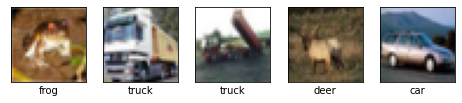

--------------------
Testing images : 10000 images.


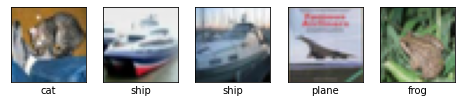

In [9]:
# Visualize CIFAR-10
print('Training images : ' + str(X_train.shape[0]) + ' images.')
plot_images(X_train[:5], y_train[:5])
print(20 * '-')
print('Testing images : ' + str(X_test.shape[0]) + ' images.')
plot_images(X_test[:5], y_test[:5])

### The Model

In [27]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3

    x = layers.Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    left = layers.Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    right = layers.Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    x = layers.concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

In [28]:
def SqueezeNet(input_shape=IN_SHAPE, classes=10):

    img_input = layers.Input(shape=input_shape)

    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.Activation('relu', name='relu_conv1')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
#     x = layers.Dropout(0.2, name='drop9')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1, name='drop11')(x)

    out = layers.Activation('softmax', name='loss')(x) 
    model = models.Model(img_input, out, name='squeezenet')

    return model

In [29]:
def compile_model(model):
    opt = optimizers.Adam(lr=0.0001)#, momentum=0.9)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
    return model

In [30]:
sn = SqueezeNet()
sn = compile_model(sn)
sn.summary()
len(sn.layers)

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
_________________________________________________________________________________________

40

### Training

In [34]:
def run_test_harness(model, X_train, y_train, X_test, y_test):
    """
    function takes model X,Y train test arguments and create data generator for fit and evaluate.
    return summarize diagnostics.
    """
#     datagen = tf_ppimg.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2, horizontal_flip=True)
#     # prepare iterator
#     it_train = datagen.flow(X_train, y_train, batch_size=64)

    batch_size = 64
    # Generator for train and validation data
    datagen = tf_ppimg.ImageDataGenerator(validation_split=0.2,
                                          width_shift_range=0.1, 
                                          height_shift_range=0.1,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True)
    
    train_generator = datagen.flow(x=X_train,    
                                   y=y_train,  
                                   batch_size=batch_size,
                                   seed=39,
                                   shuffle=True,
                                   subset='training')
    
    val_generator = datagen.flow(X_train, 
                                 y_train,
                                 seed=39,
                                 shuffle=True,
                                 batch_size=batch_size,
                                 subset='validation')

    # test datagen
    test_datagen = tf_ppimg.ImageDataGenerator(rescale=1./255)
    
    # fit model
    steps = train_generator.n//batch_size
    history = model.fit(train_generator, 
                        steps_per_epoch=steps, 
                        epochs=400, 
                        validation_data=val_generator,
                        validation_steps=val_generator.n//batch_size)
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    print('> %.3f' % (acc * 100.0))

    return history

In [35]:
# entry point, run the test harness
history = run_test_harness(sn, X_train, y_train, X_test, y_test)

Epoch 1/400
625/625 [==============================] - 22s 34ms/step - loss: 1.6064 - accuracy: 0.4381 - val_loss: 1.5296 - val_accuracy: 0.4594
Epoch 2/400
625/625 [==============================] - 22s 35ms/step - loss: 1.5507 - accuracy: 0.4591 - val_loss: 1.5537 - val_accuracy: 0.4401
Epoch 3/400
625/625 [==============================] - 22s 34ms/step - loss: 1.5106 - accuracy: 0.4735 - val_loss: 1.4407 - val_accuracy: 0.4993
Epoch 4/400
625/625 [==============================] - 22s 34ms/step - loss: 1.4777 - accuracy: 0.4888 - val_loss: 1.3902 - val_accuracy: 0.5075
Epoch 5/400
625/625 [==============================] - 22s 35ms/step - loss: 1.4462 - accuracy: 0.4990 - val_loss: 1.4012 - val_accuracy: 0.5096
Epoch 6/400
625/625 [==============================] - 22s 35ms/step - loss: 1.4162 - accuracy: 0.5114 - val_loss: 1.5233 - val_accuracy: 0.4685
Epoch 7/400
625/625 [==============================] - 21s 34ms/step - loss: 1.3908 - accuracy: 0.5188 - val_loss: 1.3296 - val_ac

### save model architecture

In [82]:
save = input('Do you want to save last run (y/n) ?')
if save == 'y':
    model_json = sn.to_json()
    with open('squeeze_net_model2.json', 'w') as f:
        f.write(model_json)

    with open('history_model2.json', 'w') as f:
        json.dump(history.history, f)

    # save model's learned weights
    sn.save('model2.h5', overwrite=True)
    
load = input('Do you want to load best model (y/n) ? ')
if load == 'y':
    sn = load_model(os.path.join(os.getcwd(), 'saves//model.h5'))
    history = json.load(open(os.path.join(os.getcwd(), 'saves//history_model2.json')))

Do you want to save last run (y/n) ? n
Do you want to load best model (y/n) ?  y


### Model Evaluation

In [83]:
evaluate = sn.evaluate(X_test, y_test)
print(f'{list(zip(evaluate, sn.metrics_names))}')

313/313 [==============================] - 1s 4ms/step - loss: 0.5846 - accuracy: 0.8143
[(0.5846203565597534, 'loss'), (0.814300000667572, 'accuracy')]


In [63]:
def plot_accuracy_and_loss(history):
    "function reads model's history and plot its train and validation - acc and loss over the run"
    plt.figure(1, figsize= (15, 10))
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plot train and test loss
    plt.subplot(222)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show();   
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

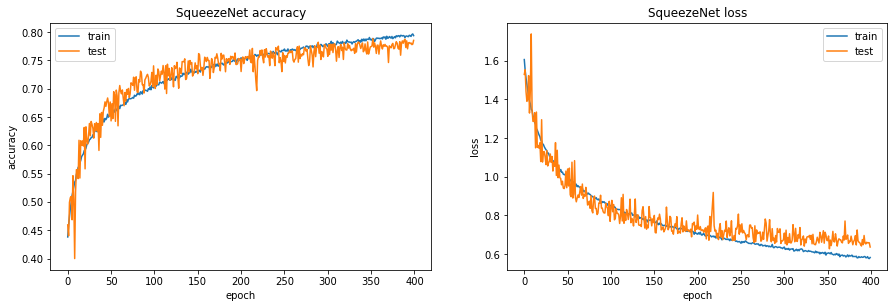

In [64]:
plot_accuracy_and_loss(history)

#### Confusion Matrix

In [84]:
y_pred = sn.predict(X_test)
y_pred_classes = [np.argmax(el) for el in y_pred]
preds=np.argmax(y_pred, axis=1)
tests=np.argmax(y_test, axis=1)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      1000
           1       0.93      0.86      0.90      1000
           2       0.78      0.76      0.77      1000
           3       0.67      0.68      0.68      1000
           4       0.79      0.83      0.81      1000
           5       0.84      0.62      0.71      1000
           6       0.78      0.90      0.84      1000
           7       0.89      0.84      0.87      1000
           8       0.77      0.96      0.85      1000
           9       0.90      0.86      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



Text(33.0, 0.5, 'True')

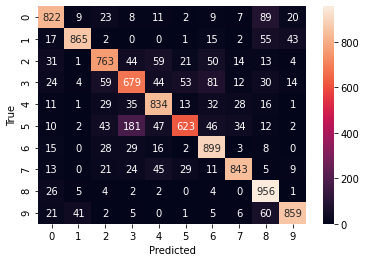

In [85]:
cr = classification_report(tests, preds)
print(f'Classification Report:\n {cr}')
cm = tf.math.confusion_matrix(labels=tests, predictions=preds, num_classes=10)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [86]:
# {0: 'plane',
#  1: 'car',
#  2: 'bird',
#  3: 'cat',
#  4: 'deer',
#  5: 'dog',
#  6: 'frog',
#  7: 'horse',
#  8: 'ship',
#  9: 'truck'}

### Inference

In [87]:
def predict_label(model, labels, imagepath):

    img = tf.keras.preprocessing.image.load_img(os.path.join(imagepath), target_size=(32, 32))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, 0)      # Create batch axis (32, 32, 3) => (1, 32, 32, 3)

    predictions = model.predict(img_array)[0]
    index = np.argmax(predictions)
    result = labels[int(index)]
    imge = plt.imread(imagepath)
    plt.figure(figsize=(5, 5))
    plt.imshow(imge)
    plt.title(f'prediction: {result}')
    plt.xticks([])
    plt.yticks([])
    plt.show();
    return result

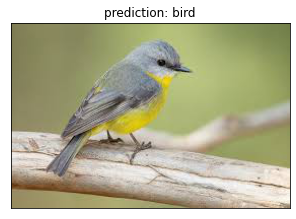

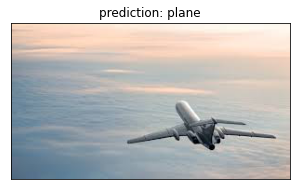

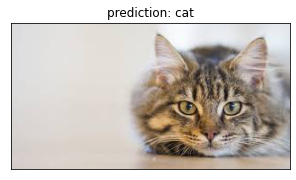

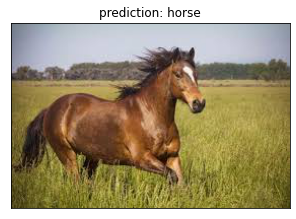

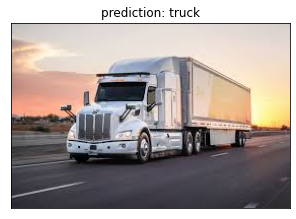

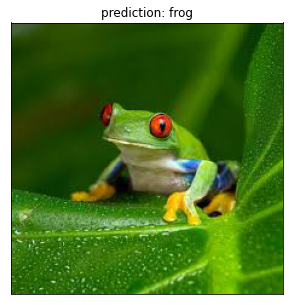

In [97]:
# Checks new images from google image
for fig in range(1,7):
    path = os.path.join(os.getcwd(), f'static//uploads//{fig}.jpg')
    predict_label(sn, LBL, path)